In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [3]:
project_path = '/content/drive/MyDrive/anomaly-detection'

normal = pd.read_hdf(f'{project_path}/data/training_normal.h5')
mean = pd.read_hdf(f'{project_path}/data/norm.h5', key='mean')
std = pd.read_hdf(f'{project_path}/data/norm.h5', key='std')

normal_data = normal.iloc[:, 3:]
normalized_data = (normal_data - mean) / std

normalized_data.head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.003307,0.300364,0.514599,-1.342731,-0.062398,0.294726,-0.098047,-0.252914,0.522186,0.089759,-0.263281,1.424527,-0.110565,-0.129407,0.519562,-0.172634,-0.209424,-0.162180,-0.246119,-0.128175,0.302922,-0.950211,-0.000524,-0.001539,-0.001144,-0.000454,0.001316,-0.004213,-0.007948,0.001812,0.004263,-0.001579,0.003519,0.000138,-0.002805,0.006490,-0.001346,-0.000284,0.004503,-0.004778,0.002143,-0.287051,-0.489006,0.005770,1.001362,-0.150228,-0.078897,1.424527,0.520011,-0.165134,0.284191,0.224294
1,0.019690,-0.128967,1.218404,0.925080,-0.856779,1.091016,-0.005032,-0.000158,0.522186,-0.068269,-0.120774,0.153207,0.003854,-0.729772,-1.208793,-0.034589,0.623874,-0.199781,-0.156369,-0.079685,-0.039833,0.533895,-0.000524,-0.001539,-0.001144,-0.000454,0.001316,-0.004213,-0.007948,0.001812,0.004263,-0.001579,0.003519,0.000138,-0.002805,0.006490,-0.001346,-0.000284,0.004503,-0.004778,0.002143,0.142713,-1.191637,-0.016944,-1.639727,-0.250199,0.078954,0.153478,-1.208816,-0.195688,0.470946,-0.631769
2,-0.003307,-0.102502,-0.791010,1.114064,-0.128596,-1.224631,0.154424,-0.422647,1.045513,-0.113762,0.474405,0.300089,0.219978,0.082198,0.069757,0.195487,-1.660402,-0.162180,-0.200762,-0.031195,0.036335,0.656612,-1.448834,-1.194439,-0.912958,-0.522491,0.630922,-1.078046,0.072110,-0.746759,-0.205673,0.426909,0.558892,-0.116555,0.158677,1.721015,-0.001346,-0.000284,0.004503,-0.004778,0.002143,0.117030,0.816185,0.008733,-0.018895,0.308127,0.123493,0.300513,0.070048,-0.180595,0.175097,1.647422
3,-0.023065,-0.073095,0.083646,1.522363,-0.681826,-1.256665,0.287304,0.413106,-0.524468,-0.121743,0.830674,-0.009554,0.232691,-1.862593,0.428026,0.088118,-0.000289,-0.047027,-0.410179,0.168825,-0.969081,0.568409,-1.448834,-1.194439,-0.912958,-0.522491,0.630922,-1.078046,0.072110,-0.746759,-0.205673,0.426909,0.558892,-0.116555,0.158677,1.721015,-0.001346,-0.000284,0.004503,-0.004778,0.002143,0.087922,-0.058910,0.028155,-1.159749,0.113845,0.132008,-0.009071,0.428147,-0.110653,0.996077,-0.020296
4,1.411175,0.447396,-0.301407,-0.105001,-0.062398,1.429668,0.008256,0.715675,-0.524468,-0.856811,-0.179453,1.300471,-0.174131,0.923694,0.472318,0.195487,-0.227258,-0.030577,-0.076270,-0.194849,0.592360,-1.333701,0.460458,-2.997750,1.220939,-0.123286,0.021735,-0.671942,0.327111,0.103470,0.652214,-1.600546,0.263290,-1.656155,-0.202016,-1.062742,-0.001346,-0.000284,0.004503,-0.004778,0.002143,0.452622,-0.672116,1.368624,-0.467518,-0.508613,-0.596991,1.300424,0.472378,-0.225506,0.744606,0.233859


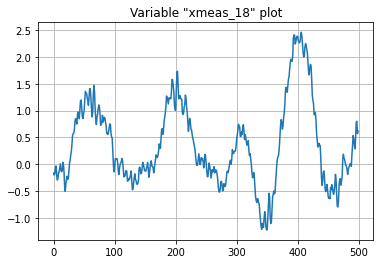

In [4]:
variable = 'xmeas_18'

plt.grid()
plt.plot(normalized_data.index[:500], normalized_data[variable][:500])
plt.title(f'Variable "{variable}" plot')
plt.show()

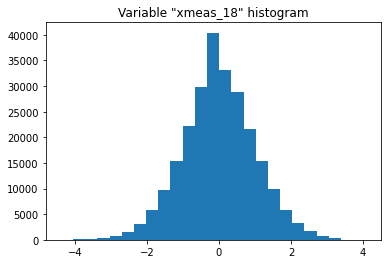

In [5]:
plt.hist(normalized_data[variable], bins=25)
plt.title(f'Variable "{variable}" histogram')
plt.show()

In [6]:
train_data, valid_data = train_test_split(normalized_data.values, test_size=0.2)
print(f'train data size: {train_data.shape}')
print(f'valid data size: {valid_data.shape}')

input_dim =  train_data.shape[1]

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)

train data size: (200000, 52)
valid data size: (50000, 52)


In [95]:
class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim // 3, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(input_dim)

In [96]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), 
              loss=tf.losses.MeanSquaredError(), 
              metrics=[tf.metrics.MeanSquaredError()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 min_lr=0.0001,
                                                 verbose=1)

In [ ]:
history = model.fit(train_data, train_data, 
                    epochs=100, 
                    batch_size=256, 
                    validation_data=(valid_data, valid_data), 
                    shuffle=True, 
                    callbacks=[reduce_lr])

Epoch 1/100
782/782 [==============================] - 3s 3ms/step - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.3993 - val_mean_squared_error: 0.3993
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 0.3986 - mean_squared_error: 0.3986 - val_loss: 0.3973 - val_mean_squared_error: 0.3973
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 0.3965 - mean_squared_error: 0.3965 - val_loss: 0.3926 - val_mean_squared_error: 0.3926
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 0.3827 - mean_squared_error: 0.3827 - val_loss: 0.3729 - val_mean_squared_error: 0.3729
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 0.3691 - mean_squared_error: 0.3691 - val_loss: 0.3616 - val_mean_squared_error: 0.3616
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 0.3561 - mean_squared_error: 0.3561 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 7/100
782/782 [=

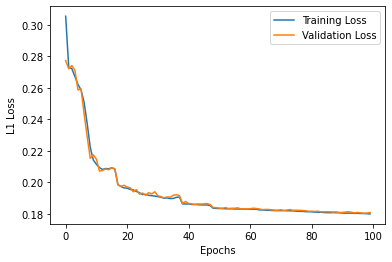

In [88]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

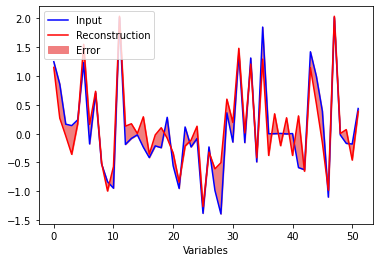

In [92]:
encoded_data = model.encoder(train_data).numpy()
decoded_data = model.decoder(encoded_data).numpy()

index = 1
plt.plot(train_data[index], 'b')
plt.plot(decoded_data[index], 'r')
plt.fill_between(np.arange(52), decoded_data[index], train_data[index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('Variables')
plt.show()

In [94]:
encoded_data[index]

array([1.5082954 , 0.5703572 , 0.7611357 , 0.3313443 , 1.1946443 ,
       0.        , 1.054124  , 1.9735677 , 0.9448969 , 1.3062999 ,
       0.5375215 , 0.        , 1.1155738 , 0.        , 1.2375009 ,
       0.91448975, 0.5818467 , 0.        , 0.7344273 , 0.72340024,
       0.8397743 , 0.96038914, 0.83528084, 1.0105069 , 0.42067552,
       0.        ], dtype=float32)